<a href="https://colab.research.google.com/github/Zabihuddin/data_analysis/blob/main/Real_Time__DDOS_data_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python3 --version


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5822 - val_loss: 2.1173
Epoch 2/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4531 - val_loss: 2.1906
Epoch 3/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4817 - val_loss: 2.2242
Epoch 4/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.4598 - val_loss: 2.2336
Epoch 5/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4688 - val_loss: 2.2397
Epoch 6/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.4656 - val_loss: 2.2507
Epoch 7/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4636 - val_loss: 2.2612
Epoch 8/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4725 - val_loss: 2.2669
Epoch 9/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4580 - val_loss: 2.2740
Epoch 10/10
741/741 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.4513 - val_loss: 2.2777
3293/3293 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
✅ Final Accu

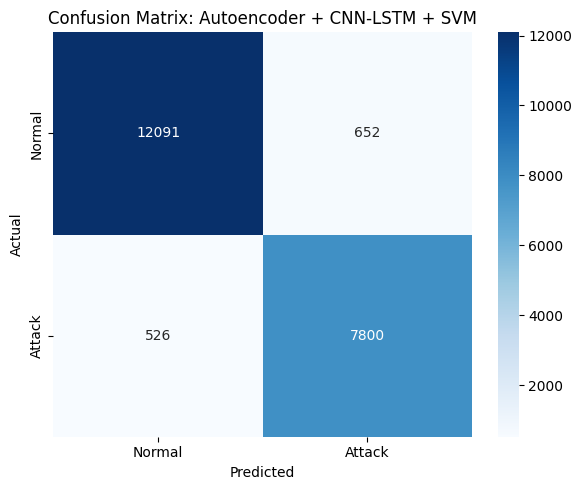

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TerminateOnNaN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load and Merge Data ===
data_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/dataset_sdn.csv')
data_gan = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/gan_synthetic_data (3).csv')

data_original.columns = data_original.columns.str.lower()
data_gan.columns = data_gan.columns.str.lower()

# Align column names
all_columns = sorted(set(data_original.columns).union(set(data_gan.columns)))
for col in all_columns:
    if col not in data_original.columns:
        data_original[col] = 0
    if col not in data_gan.columns:
        data_gan[col] = 0

data_original = data_original[all_columns]
data_gan = data_gan[all_columns]

# 🔧 Ensure unique columns before concat
data_original = data_original.loc[:, ~data_original.columns.duplicated()]
data_gan = data_gan.loc[:, ~data_gan.columns.duplicated()]

data_combined = pd.concat([data_original, data_gan], ignore_index=True)

# === Step 2: Feature Engineering ===
tls_features = [col for col in ['tls_version', 'tls_cipher'] if col in data_combined.columns]
numeric_features = [
    'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur', 'flows',
    'packetins', 'pktperflow', 'byteperflow', 'pktrate',
    'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps',
    'protocol'
]
feature_cols = [col for col in tls_features + numeric_features if col in data_combined.columns]
X_df = data_combined[feature_cols].copy()

X_df = X_df.apply(pd.to_numeric, errors='coerce')
X_df = X_df.fillna(X_df.mean(numeric_only=True))
X_encoded = pd.get_dummies(X_df)

# === Step 3: Features and Labels ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X = X_scaled.astype(np.float32)
y = np.clip(data_combined['label'].astype(int).values, 0, 1)

# === Step 4: Autoencoder for Feature Compression ===
def build_autoencoder(input_dim, encoding_dim=64):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

autoencoder, encoder = build_autoencoder(X.shape[1], encoding_dim=64)
autoencoder.fit(X, X, epochs=10, batch_size=128, validation_split=0.1, verbose=1)

# === Step 5: Encode features using Autoencoder ===
X_encoded = encoder.predict(X)

# === Step 6: Reshape for CNN-LSTM ===
X_encoded_reshaped = X_encoded.reshape((X_encoded.shape[0], 1, X_encoded.shape[1]))
X_train_dl, X_test_dl, y_train, y_test = train_test_split(X_encoded_reshaped, y, test_size=0.2, random_state=42)

# === Step 7: CNN-LSTM Model ===
def build_cnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    model = Model(inputs, x)
    return model

cnn_lstm_model = build_cnn_lstm_model((X_train_dl.shape[1], X_train_dl.shape[2]))

# === Step 8: Feature Extraction ===
train_features = cnn_lstm_model.predict(X_train_dl)
test_features = cnn_lstm_model.predict(X_test_dl)
train_features = np.nan_to_num(train_features)
test_features = np.nan_to_num(test_features)

# === Step 9: SVM Classification ===
svm = SVC(probability=True)
svm.fit(train_features, y_train)

# === Step 10: Evaluation ===
y_pred = svm.predict(test_features)
print("✅ Final Accuracy:", accuracy_score(y_test, y_pred))
print("🔍 Classification Report:\n", classification_report(y_test, y_pred))

# === Step 11: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
labels = ["Normal", "Attack"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: Autoencoder + CNN-LSTM + SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


Epoch 1/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.1340 - val_loss: 1.7267
Epoch 2/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0022 - val_loss: 1.7295
Epoch 3/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0018 - val_loss: 1.7291
Epoch 4/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0010 - val_loss: 1.7467
Epoch 5/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.6306e-04 - val_loss: 1.7561
Epoch 6/50
741/741 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.8489e-04 - val_loss: 1.7669
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


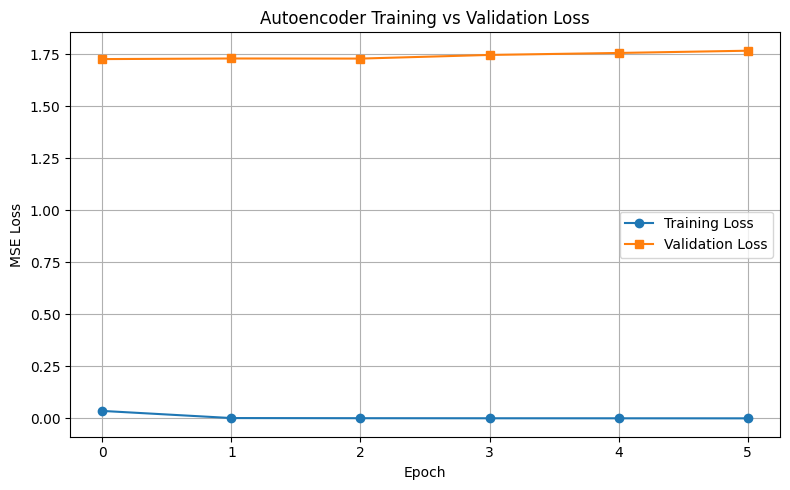

3293/3293 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
2634/2634 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
659/659 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
✅ Final Accuracy: 0.9457022165266505
🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95     12743
           1       0.92      0.94      0.93      8326

    accuracy                           0.95     21069
   macro avg       0.94      0.95      0.94     21069
weighted avg       0.95      0.95      0.95     21069



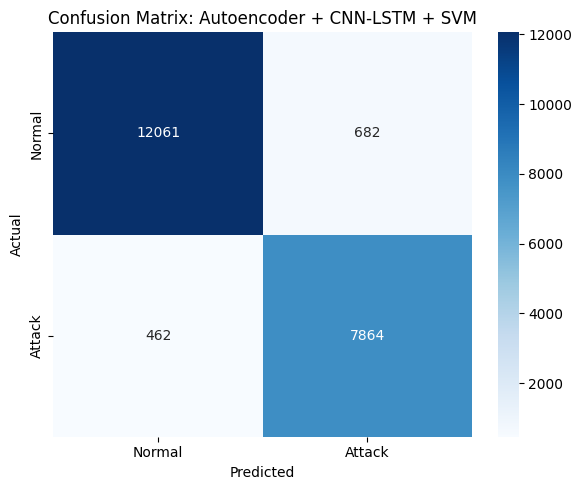

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# === Step 1: Load and Merge Data ===
data_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/dataset_sdn.csv')
data_gan = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/gan_synthetic_data (3).csv')


data_original.columns = data_original.columns.str.lower()
data_gan.columns = data_gan.columns.str.lower()

# Align column names
all_columns = sorted(set(data_original.columns).union(set(data_gan.columns)))
for col in all_columns:
    if col not in data_original.columns:
        data_original[col] = 0
    if col not in data_gan.columns:
        data_gan[col] = 0

data_original = data_original[all_columns]
data_gan = data_gan[all_columns]

# 🔧 Ensure unique columns before concat
data_original = data_original.loc[:, ~data_original.columns.duplicated()]
data_gan = data_gan.loc[:, ~data_gan.columns.duplicated()]

data_combined = pd.concat([data_original, data_gan], ignore_index=True)

# === Step 2: Feature Engineering ===
tls_features = [col for col in ['tls_version', 'tls_cipher'] if col in data_combined.columns]
numeric_features = [
    'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur', 'flows',
    'packetins', 'pktperflow', 'byteperflow', 'pktrate',
    'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps',
    'protocol'
]
feature_cols = [col for col in tls_features + numeric_features if col in data_combined.columns]
X_df = data_combined[feature_cols].copy()

X_df = X_df.apply(pd.to_numeric, errors='coerce')
X_df = X_df.fillna(X_df.mean(numeric_only=True))
X_encoded = pd.get_dummies(X_df)

# === Step 3: Features and Labels ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X = X_scaled.astype(np.float32)
y = np.clip(data_combined['label'].astype(int).values, 0, 1)
from tensorflow.keras.callbacks import EarlyStopping

# === Step 4: Autoencoder with Improvements ===
def build_autoencoder(input_dim, encoding_dim=64):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='linear')(decoded)  # Linear or ReLU works better for continuous output
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return autoencoder, encoder

autoencoder, encoder = build_autoencoder(X.shape[1], encoding_dim=64)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = autoencoder.fit(
    X, X,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# === Step 4.1: Plot Autoencoder Training & Validation Loss ===
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Autoencoder Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# === Step 5: Encode features using Autoencoder ===
X_encoded = encoder.predict(X)

# === Step 6: Reshape for CNN-LSTM ===
X_encoded_reshaped = X_encoded.reshape((X_encoded.shape[0], 1, X_encoded.shape[1]))
X_train_dl, X_test_dl, y_train, y_test = train_test_split(X_encoded_reshaped, y, test_size=0.2, random_state=42)

# === Step 7: CNN-LSTM Model ===
def build_cnn_lstm_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = LSTM(64, return_sequences=False)(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    model = Model(inputs, x)
    return model

cnn_lstm_model = build_cnn_lstm_model((X_train_dl.shape[1], X_train_dl.shape[2]))

# === Step 8: Feature Extraction ===
train_features = cnn_lstm_model.predict(X_train_dl)
test_features = cnn_lstm_model.predict(X_test_dl)
train_features = np.nan_to_num(train_features)
test_features = np.nan_to_num(test_features)

# === Step 9: SVM Classification ===
svm = SVC(probability=True)
svm.fit(train_features, y_train)

# === Step 10: Evaluation ===
y_pred = svm.predict(test_features)
print("✅ Final Accuracy:", accuracy_score(y_test, y_pred))
print("🔍 Classification Report:\n", classification_report(y_test, y_pred))

# === Step 11: Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
labels = ["Normal", "Attack"]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: Autoencoder + CNN-LSTM + SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [ ]:
pip install kafka-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.8/309.8 kB 9.4 MB/s eta 0:00:00


In [ ]:
import requests
requests.packages.urllib3.disable_warnings()

REST_PROXY_URL = "http://127.0.0.1:8082"

r = requests.get(f"{REST_PROXY_URL}/topics", verify=False)
print("✅ Topics from REST Proxy:", r.text)


In [ ]:
!curl -X GET https://76f393ccc7a312c7.p170.r3proxy.com:8082


In [ ]:
# ✅ RUN IN: Google Colab

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import joblib

# Dummy dataset
X = np.random.rand(100, 5)
y = np.random.randint(0, 2, 100)

# Train model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

model = RandomForestClassifier()
model.fit(X_scaled, y)

# Save model and scaler
joblib.dump(model, 'rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


In [ ]:
import requests
import time

REST_PROXY = "https://fe7d3720f31ae38d.p171.r3proxy.com:8082"
MODEL_API = "http://172.22.43.148:5000/predict"
TOPIC = "ddos-topic"
GROUP = "ddos-detector-group"
INSTANCE = "realtime-consumer"

headers = {"Content-Type": "application/vnd.kafka.v2+json"}

# ✅ 1. Create Consumer with required header
res = requests.post(
    f"{REST_PROXY}/consumers/{GROUP}",
    headers=headers,
    json={
        "name": INSTANCE,
        "format": "json",
        "auto.offset.reset": "latest"
    }
)
print("Response from REST Proxy (consumer creation):", res.status_code, res.text)
res.raise_for_status()
base_uri = res.json()['base_uri']

# ✅ 2. Subscribe to topic
requests.post(
    f"{base_uri}/subscription",
    headers=headers,
    json={"topics": [TOPIC]}
)

print("✅ Listening to Kafka...")
while True:
    res = requests.get(f"{base_uri}/records", timeout=5, headers=headers)
    if res.status_code == 200:
        for record in res.json():
            features = record['value']
            pred = requests.post(MODEL_API, json={"features": features}).json()
            print("Prediction:", pred)
    time.sleep(2)


In [ ]:
!curl -k https://dcc29935e4a2447d.p171.r3proxy.com/topics


In [ ]:
!curl -k http://localhost:8082/topics


In [ ]:
import requests
import json
import time
import random

REST_PROXY_URL = "https://dcc29935e4a2447d.p171.r3proxy.com"
TOPIC = "ddos-topic"

headers = {
    "Content-Type": "application/vnd.kafka.json.v2+json",
    "Accept": "application/vnd.kafka.v2+json"
}

def generate_sample_record():
    return {
        "packet_size": random.randint(100, 1500),
        "flow_duration": random.randint(1000, 10000),
        "label": random.choice(["BENIGN", "DDoS"])
    }

while True:
    data = {
        "records": [
            {"value": generate_sample_record()},
            {"value": generate_sample_record()}
        ]
    }

    response = requests.post(
        f"{REST_PROXY_URL}/topics/{TOPIC}",
        headers=headers,
        data=json.dumps(data),
        verify=False
    )

    print("✅ Sent batch:", response.status_code, response.text)
    time.sleep(2)


***#DDOS_Setup with wsl\***




In [ ]:
!pip install tensorflow==2.15.0 tensorflow-model-optimization==0.7.5

!pip install numpy==1.25.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing install

ERROR: Operation cancelled by user
^C


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TerminateOnNaN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# --- Step 1: Load and Merge Data ---
data_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/dataset_sdn.csv')
data_gan = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tools & technique/dataset/gan_synthetic_data (3).csv')

data_original.columns = data_original.columns.str.lower()
data_gan.columns = data_gan.columns.str.lower()

# Align column names
all_columns = sorted(set(data_original.columns).union(set(data_gan.columns)))
for col in all_columns:
    if col not in data_original.columns:
        data_original[col] = 0
    if col not in data_gan.columns:
        data_gan[col] = 0

data_original = data_original[all_columns]
data_gan = data_gan[all_columns]

# 🔧 Ensure unique columns before concat
data_original = data_original.loc[:, ~data_original.columns.duplicated()]
data_gan = data_gan.loc[:, ~data_gan.columns.duplicated()]

data_combined = pd.concat([data_original, data_gan], ignore_index=True)

# --- Step 2: Feature Engineering ---
tls_features = [col for col in ['tls_version', 'tls_cipher'] if col in data_combined.columns]
numeric_features = [
    'pktcount', 'bytecount', 'dur', 'dur_nsec', 'tot_dur', 'flows',
    'packetins', 'pktperflow', 'byteperflow', 'pktrate',
    'port_no', 'tx_bytes', 'rx_bytes', 'tx_kbps', 'rx_kbps', 'tot_kbps',
    'protocol'
]
feature_cols = [col for col in tls_features + numeric_features if col in data_combined.columns]
X_df = data_combined[feature_cols].copy()

# Fill numeric columns and one-hot encode
X_df = X_df.apply(pd.to_numeric, errors='coerce')
X_df = X_df.fillna(X_df.mean(numeric_only=True))
X_encoded = pd.get_dummies(X_df)

# --- Step 3: Prepare Features and Labels ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X = X_scaled.astype(np.float32)
y = np.clip(data_combined['label'].astype(int).values, 0, 1)

# --- Step 4: Reshape and Split ---
X = X.reshape((X.shape[0], 1, X.shape[1]))
X_train_dl, X_test_dl, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Step 5: Build Improved CNN-LSTM Model ---
def build_improved_cnn_lstm(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LSTM(64)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

model = build_improved_cnn_lstm(X_train_dl.shape[1:])
optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# --- Step 6: Class Weights ---
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# --- Step 7: Train ---
model.fit(
    X_train_dl, y_train,
    validation_split=0.1,
    epochs=12,
    batch_size=64,
    callbacks=[TerminateOnNaN()],
    class_weight=class_weights_dict,
    verbose=1
)

# --- Step 8: Feature Extraction ---
feature_model = Model(inputs=model.input, outputs=model.layers[-2].output)
train_features = feature_model.predict(X_train_dl)
test_features = feature_model.predict(X_test_dl)

# Replace any NaNs (if any)
train_features = np.nan_to_num(train_features)
test_features = np.nan_to_num(test_features)

# --- Step 9: Train SVM ---
svm = SVC(probability=True)
svm.fit(train_features, y_train)

# --- Step 10: Evaluate ---
preds = svm.predict(test_features)
print("✅ Hybrid CNN-LSTM-SVM Ensemble Accuracy:", accuracy_score(y_test, preds))
print("🔍 Classification Report:\n", classification_report(y_test, preds))


Epoch 1/12
1186/1186 [==============================] - 14s 7ms/step - loss: 0.1355 - accuracy: 0.9408 - val_loss: 0.0724 - val_accuracy: 0.9696
Epoch 2/12
1186/1186 [==============================] - 8s 7ms/step - loss: 0.0718 - accuracy: 0.9696 - val_loss: 0.0586 - val_accuracy: 0.9775
Epoch 3/12
1186/1186 [==============================] - 8s 7ms/step - loss: 0.0604 - accuracy: 0.9750 - val_loss: 0.0491 - val_accuracy: 0.9814
Epoch 4/12
1186/1186 [==============================] - 7s 6ms/step - loss: 0.0543 - accuracy: 0.9773 - val_loss: 0.0463 - val_accuracy: 0.9814
Epoch 5/12
1186/1186 [==============================] - 9s 7ms/step - loss: 0.0508 - accuracy: 0.9790 - val_loss: 0.0346 - val_accuracy: 0.9839
Epoch 6/12
1186/1186 [==============================] - 7s 6ms/step - loss: 0.0469 - accuracy: 0.9804 - val_loss: 0.0346 - val_accuracy: 0.9861
Epoch 7/12
1186/1186 [==============================] - 8s 7ms/step - loss: 0.0445 - accuracy: 0.9818 - val_loss: 0.0323 - val_accuracy

In [ ]:
# Save CNN-LSTM model
model.save('cnn_lstm_model.keras')

# Save feature extraction model
feature_model.save('cnn_lstm_feature_model.keras')

# Save SVM and Scaler
import joblib
joblib.dump(svm, 'svm_classifier.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(X_encoded.columns.tolist(), 'feature_columns.pkl')  # save column names for encoding consistency


['feature_columns.pkl']

In [ ]:
!pip install fastapi[all] uvicorn nest_asyncio joblib tensorflow
!pip install pyngrok  # for public URL


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.8/459.8 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 453.1/453.1 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.6/950.6 kB 54.8 MB/s eta 0:00:00


In [ ]:
!pip install fastapi nest_asyncio pyngrok uvicorn


In [ ]:
import numpy as np
import joblib
import pandas as pd
from fastapi import FastAPI
from pydantic import BaseModel
from tensorflow.keras.models import load_model
from datetime import datetime
import nest_asyncio
import uvicorn
from pyngrok import ngrok

# Enable nested asyncio (for Colab)
nest_asyncio.apply()

app = FastAPI(title="Hybrid DDoS Detection API")

# Load models
scaler = joblib.load("/content/scaler.joblib")
svm_model = joblib.load("/content/svm_classifier.joblib")
feature_columns = joblib.load("/content/feature_columns.pkl")
feature_model = load_model("/content/cnn_lstm_feature_model.keras", compile=False)

latest_result = {}

# Input schema (structured)
class TrafficSample(BaseModel):
    pktcount: float = 0
    bytecount: float = 0
    dur: float = 0
    dur_nsec: float = 0
    tot_dur: float = 0
    flows: float = 0
    packetins: float = 0
    pktperflow: float = 0
    byteperflow: float = 0
    pktrate: float = 0
    port_no: float = 0
    tx_bytes: float = 0
    rx_bytes: float = 0
    tx_kbps: float = 0
    rx_kbps: float = 0
    tot_kbps: float = 0
    protocol: float = 0
    tls_version: float = 0
    tls_cipher: float = 0

@app.get("/")
def root():
    return {"message": "✅ Hybrid CNN-LSTM-SVM DDoS API running. Use /predict"}

@app.post("/predict")
async def predict(data: TrafficSample):
    global latest_result
    try:
        df = pd.DataFrame([data.model_dump()])


        # Fill missing columns and align order
        for col in feature_columns:
            if col not in df.columns:
                df[col] = 0
        df = df[feature_columns]

        # Scale and reshape
        X_scaled = scaler.transform(df)
        X_input = X_scaled.reshape((1, 1, X_scaled.shape[1]))

        # Extract CNN-LSTM features
        features = feature_model.predict(X_input)
        features = np.nan_to_num(features)

        # SVM prediction
        pred = svm_model.predict(features)[0]
        prob = svm_model.predict_proba(features)[0][1]

        latest_result = {
            "timestamp": datetime.now().isoformat(),
            "prediction": int(pred),
            "attack_probability": float(prob),
            "label": "ATTACK" if pred == 1 else "BENIGN"
        }
        return latest_result

    except Exception as e:
        return {"error": str(e)}

@app.get("/latest")
async def get_latest():
    return latest_result


In [ ]:
from pyngrok import ngrok
import uvicorn
import nest_asyncio

import nest_asyncio
nest_asyncio.apply()

ngrok.kill()  # Stop previous tunnels if any
public_url = ngrok.connect(8000)
print("🚀 Public FastAPI URL:", public_url)

uvicorn.run(app, host="0.0.0.0", port=8000)


🚀 Public FastAPI URL: NgrokTunnel: "https://848ede3629bd.ngrok-free.app" -> "http://localhost:8000"


INFO:     Started server process [1425]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


1/1 [==============================] - 0s 27ms/step
INFO:     119.154.240.179:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 24ms/step
INFO:     119.154.240.179:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 24ms/step
INFO:     119.154.240.179:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 37ms/step
INFO:     119.154.240.179:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 33ms/step
INFO:     119.154.240.179:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 35ms/step
INFO:     119.154.240.179:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 35ms/step
INFO:     119.154.240.179:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 23ms/step
INFO:     119.154.240.179:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 21ms/step
INFO:     119.154.240.179:0 - "POST 

ERROR:asyncio:Task exception was never retrieved
future: <Task finished name='Task-452' coro=<Server.serve() done, defined at /usr/local/lib/python3.11/dist-packages/uvicorn/server.py:69> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/main.py", line 580, in run
    server.run()
  File "/usr/local/lib/python3.11/dist-packages/uvicorn/server.py", line 67, in run
    return asyncio.run(self.serve(sockets=sockets))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/usr/local/lib/python3.11/dist-packages/nest_asyncio.py", line 133, in _run_once
    handle._run()
  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run
    

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
INFO:     119.154.240.179:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 25ms/step
INFO:     119.154.240.179:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 42ms/step
INFO:     119.154.240.179:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 39ms/step
INFO:     119.154.240.179:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 36ms/step
INFO:     119.154.240.179:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 27ms/step
INFO:     119.154.240.179:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 29ms/step
INFO:     119.154.240.179:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] - 0s 26ms/step
INFO:     119.154.240.179:0 - "POST /predict HTTP/1.1" 200 OK
1/1 [==============================] 

In [ ]:
from google.colab import files
uploaded = files.upload()  # then select the two files manually


Saving cnn_lstm_model.keras to cnn_lstm_model.keras
Saving scaler (1).pkl to scaler (1).pkl


In [ ]:
import numpy as np
import joblib
from fastapi import FastAPI, Request
from pydantic import BaseModel
from tensorflow.keras.models import load_model
from datetime import datetime
import nest_asyncio
import uvicorn
from pyngrok import ngrok

# Patch asyncio event loop (for Colab)
nest_asyncio.apply()

app = FastAPI(title="DDoS Detection API")

# Load model and scaler
model = load_model("/content/cnn_lstm_model.keras", compile=False)
scaler = joblib.load("/content/scaler (1).pkl")

latest_prediction = {}

# Input schema
class FeatureInput(BaseModel):
    features: list

@app.get("/")
def root():
    return {"message": "✅ DDoS Detection API running. Use /predict"}

@app.post("/predict")
async def predict(data: FeatureInput):
    global latest_prediction
    try:
        input_array = np.array(data.features).reshape(1, -1)
        scaled = scaler.transform(input_array)
        prediction = model.predict(scaled)
        result = int(prediction[0][0] > 0.5)

        latest_prediction = {
            "timestamp": datetime.now().isoformat(),
            "prediction": result
        }
        return latest_prediction
    except Exception as e:
        return {"error": str(e)}

@app.get("/latest")
async def get_latest():
    return latest_prediction


In [ ]:
# Optional: Kill previous tunnels
ngrok.kill()

# Start new public tunnel
public_url = ngrok.connect(8000)
print("🚀 Public FastAPI URL:", public_url)

# Start FastAPI server
uvicorn.run(app, host="0.0.0.0", port=8000)


🚀 Public FastAPI URL: NgrokTunnel: "https://5574249b357e.ngrok-free.app" -> "http://localhost:8000"


INFO:     Started server process [27778]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)
INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [27778]


#FOR NGROK SETUP

In [ ]:
!pip install flask-ngrok
!pip install pyngrok

In [ ]:
#!wget -q -nc https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
#!tar -xvzf ngrok-v3-stable-linux-amd64.tgz


ngrok


In [ ]:
#!./ngrok config add-authtoken '2y6jEVgXHUKILK47H0WNxTpfs0v_7Qv1nL2HkEoECKhXo4pox'

!ngrok authtoken '2y6jEVgXHUKILK47H0WNxTpfs0v_7Qv1nL2HkEoECKhXo4pox'


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
import os

# Kill any existing ngrok processes
!kill -9 $(ps aux | grep ngrok | grep -v grep | awk '{print $2}') 2>/dev/null


In [ ]:
#!./ngrok http 5000


In [ ]:
# 🧹 1. Kill all previous ngrok and Python Flask servers
!kill -9 $(ps aux | grep ngrok | grep -v grep | awk '{print $2}') 2>/dev/null
!fuser -k 5000/tcp 2>/dev/null
#!fuser -k 5050/tcp 2>/dev/null

# ✅ 2. Setup
from flask import Flask
from pyngrok import ngrok
import threading

# 🔧 3. Configure Flask
app = Flask(__name__)

@app.route("/")
def index():
    return "✅ Flask is running with ngrok in Colab!"

# 🚀 4. Start ngrok tunnel (choose one open port)
port = 5000
public_url = ngrok.connect(port)
print("🔗 Public URL:", public_url)

# 🎯 5. Run Flask in background thread (non-blocking)
def run():
    app.run(port=port)

threading.Thread(target=run, daemon=True).start()


In [ ]:
!ngrok config check

Valid configuration file at /root/.config/ngrok/ngrok.yml


In [ ]:
#!lsof -i:5000
#!hostname -I


In [ ]:
!kill -9 19661




#For FAST API

In [ ]:
%%writefile mains.py

from fastapi import FastAPI
from pydantic import BaseModel

app = FastAPI()

class RequestData(BaseModel):
    input: str

@app.post("/predict")
def predict(data: RequestData):
    # Dummy prediction
    return {"prediction": f"Received: {data.input}"}

@app.get("/")
def root():
    return {"message": "✅ FastAPI server is running."}


Writing mains.py


In [ ]:
!uvicorn main:app --host 0.0.0.0 --port 8000


ERROR:    Error loading ASGI app. Could not import module "main".


#2. Socket.IO (Real-Time App) + ngrok

In [ ]:
!pip install flask_socketio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 4.7 MB/s eta 0:00:00


In [ ]:
%%writefile socket_server.py
from flask import Flask
from flask_socketio import SocketIO, emit

app = Flask(__name__)
app.config['SECRET_KEY'] = 'secret!'
socketio = SocketIO(app, cors_allowed_origins='*')

@app.route('/')
def index():
    return "✅ Socket.IO is running."

@socketio.on('message')
def handle_message(msg):
    print('📥 Received message:', msg)
    emit('response', {'data': f"You said: {msg}"})

if __name__ == '__main__':
    socketio.run(app, host='0.0.0.0', port=5000)
!const socket = io("https://your-ngrok-url.ngrok.io");

Overwriting socket_server.py


In [ ]:
!python3 socket_server.py


  File "/content/socket_server.py", line 19
    !const socket = io("https://your-ngrok-url.ngrok.io");
    ^
SyntaxError: invalid syntax


In [ ]:
!pip install fastapi uvicorn confluent-kafka pydantic



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 30.0 MB/s eta 0:00:00


#fastapi_testing

In [ ]:
#!ngrok authtoken 2y6jEVgXHUKILK47H0WNxTpfs0v_7Qv1nL2HkEoECKhXo4pox
!ngrok config add-authtoken 2y6jEVgXHUKILK47H0WNxTpfs0v_7Qv1nL2HkEoECKhXo4pox
#!ngrok http 8000


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!https://74cc1ad8b539.ngrok-free.app

In [ ]:
import requests

API_URL = "https://74cc1ad8b539.ngrok-free.app/send"  # Use your ngrok URL

data = {
    "timestamp": "2025-07-27 14:00:00",
    "src_ip": "192.168.0.5",
    "dst_ip": "192.168.0.10",
    "packet_size": 1200
}

response = requests.post(API_URL, json=data)
print(response.json())


{'status': 'sent', 'data': {'timestamp': '2025-07-27 14:00:00', 'src_ip': '192.168.0.5', 'dst_ip': '192.168.0.10', 'packet_size': 1200}}
